# FastText Experimenty

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '../Data/wiki-news-300d-1M.vec.zip'

Archive:  /content/drive/MyDrive/DP/Data/wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense, LSTM, GRU


In [ ]:
dataset = pd.read_csv('../Data/final_dataset_cnt.csv')

## Split datasetu

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## One-hot encoder

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
index_to_id_mapping = {index: author_id for index, author_id in enumerate(one_hot_encoder.categories_[0])}

## Embdding matica

In [ ]:
embeddings_index = {}
with open('wiki-news-300d-1M.vec') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 999995 word vectors.


In [ ]:
embedding_dim = 300
vocab_size = 100000
sequence_length = 8000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(X_train.values)

In [ ]:
voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 53346 words (46654 misses)


# Modely

## DNN model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.GlobalAveragePooling1D()(emb)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
output_layer =  keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 8000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 8000, 300)         30000600  
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1024)              308224

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ft_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
19/19 [==============================] - 182s 10s/step - loss: 2.8401 - accuracy: 0.0870 - val_loss: 2.8334 - val_accuracy: 0.1061
Epoch 2/15
19/19 [==============================] - 176s 10s/step - loss: 2.6723 - accuracy: 0.1655 - val_loss: 2.7011 - val_accuracy: 0.1970
Epoch 3/15
19/19 [==============================] - 177s 10s/step - loss: 2.4904 - accuracy: 0.2457 - val_loss: 2.5227 - val_accuracy: 0.2273
Epoch 4/15
19/19 [==============================] - 177s 10s/step - loss: 2.2133 - accuracy: 0.2952 - val_loss: 2.3164 - val_accuracy: 0.2576
Epoch 5/15
19/19 [==============================] - 179s 10s/step - loss: 1.9380 - accuracy: 0.4283 - val_loss: 2.2214 - val_accuracy: 0.2727
Epoch 6/15
19/19 [==============================] - 178s 10s/step - loss: 1.7572 - accuracy: 0.4454 - val_loss: 1.9455 - val_accuracy: 0.3788
Epoch 7/15
19/19 [==============================] - 178s 10s/step - loss: 1.5407 - accuracy: 0.5478 - val_loss: 1.7577 - val_accuracy: 0.4545
Epoch 

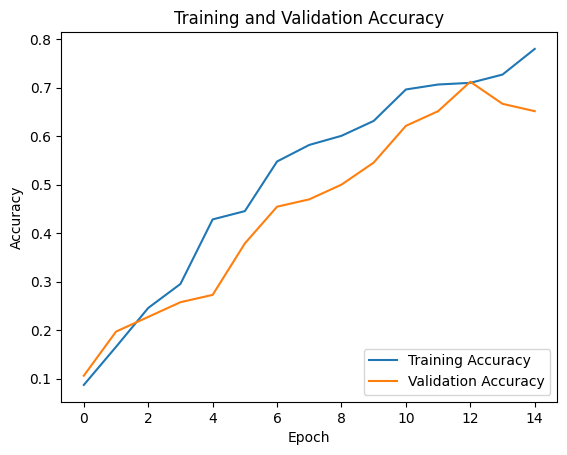

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

6/6 [==============================] - 0s 33ms/step


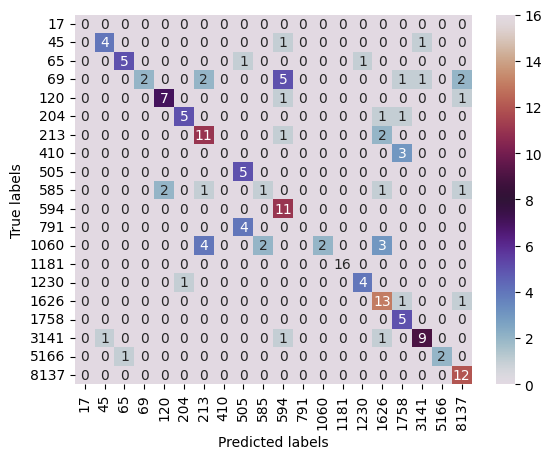

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

y_pred_ids = [index_to_id_mapping[label] for label in y_pred_labels]
y_true_ids = [index_to_id_mapping[label] for label in y_true_labels]

conf_matrix = confusion_matrix(y_true_ids, y_pred_ids, labels=list(index_to_id_mapping.values()))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=list(index_to_id_mapping.values()), yticklabels=list(index_to_id_mapping.values()), cmap="twilight")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

In [ ]:
print(conf_matrix)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0]
 [ 0  0  5  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  2  0  0  2  0  0  0  5  0  0  0  0  0  1  1  0  2]
 [ 0  0  0  0  7  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  1  1  0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0  1  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  1  0  0  1  0  0  0  0  0  1  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  2  0  0  2  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  1  0

In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.6951219512195121
F1 Score: 0.6509935343148605
Precision: 0.7281672794764616
Recall: 0.6951219512195121


## CNN Model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(emb)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 8000)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 8000, 300)         30000600  
                                                                 
 conv1d (Conv1D)             (None, 7997, 512)         614912    
                                                                 
 max_pooling1d (MaxPooling1  (None, 3998, 512)         0         
 D)                                                              
                                                                 
 global_average_pooling1d_1  (None, 512)               0   

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ft_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 12

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/12
19/19 [==============================] - 188s 10s/step - loss: 2.8352 - accuracy: 0.1263 - val_loss: 2.7694 - val_accuracy: 0.1667
Epoch 2/12
19/19 [==============================] - 177s 10s/step - loss: 2.6128 - accuracy: 0.1860 - val_loss: 2.6380 - val_accuracy: 0.2273
Epoch 3/12
19/19 [==============================] - 178s 10s/step - loss: 2.4030 - accuracy: 0.2423 - val_loss: 2.4054 - val_accuracy: 0.2424
Epoch 4/12
19/19 [==============================] - 178s 10s/step - loss: 2.1710 - accuracy: 0.3276 - val_loss: 2.2215 - val_accuracy: 0.3636
Epoch 5/12
19/19 [==============================] - 178s 10s/step - loss: 1.9893 - accuracy: 0.4334 - val_loss: 2.0801 - val_accuracy: 0.4242
Epoch 6/12
19/19 [==============================] - 180s 10s/step - loss: 1.7740 - accuracy: 0.4761 - val_loss: 1.9377 - val_accuracy: 0.4091
Epoch 7/12
19/19 [==============================] - 179s 10s/step - loss: 1.6268 - accuracy: 0.5154 - val_loss: 1.7853 - val_accuracy: 0.3788
Epoch 

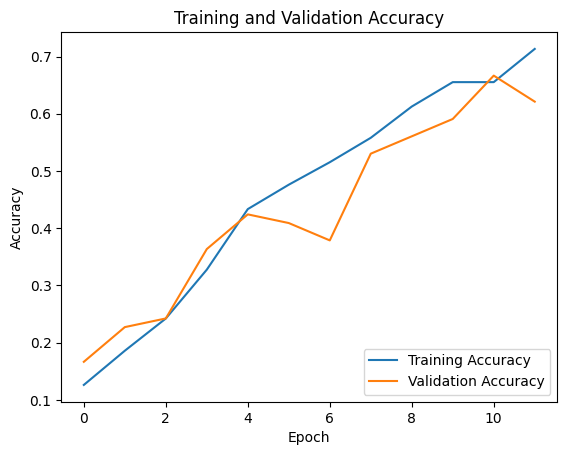

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

6/6 [==============================] - 0s 57ms/step


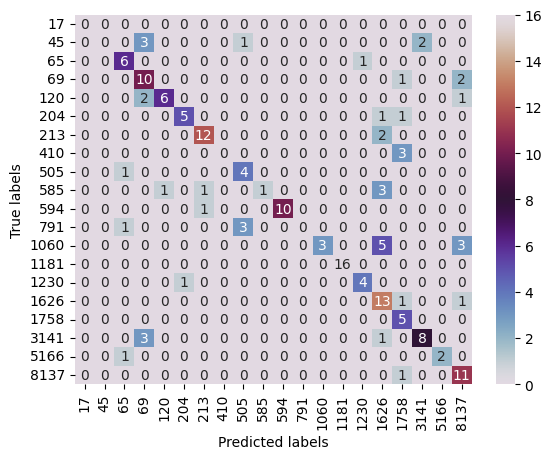

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

y_pred_ids = [index_to_id_mapping[label] for label in y_pred_labels]
y_true_ids = [index_to_id_mapping[label] for label in y_true_labels]

conf_matrix = confusion_matrix(y_true_ids, y_pred_ids, labels=list(index_to_id_mapping.values()))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=list(index_to_id_mapping.values()), yticklabels=list(index_to_id_mapping.values()), cmap="twilight")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

In [ ]:
print(conf_matrix)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  1  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  2]
 [ 0  0  0  2  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  1  1  0  0  0]
 [ 0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  1  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  1  0  0  1  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  5  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  1  0

In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.7073170731707317
F1 Score: 0.6729990630387492
Precision: 0.7180071622144792
Recall: 0.7073170731707317


## Biderectional LSTMU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(emb)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 8000)              0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 8000, 300)         30000600  
                                                                 
 bidirectional (Bidirection  (None, 8000, 256)         439296    
 al)                                                             
                                                                 
 global_average_pooling1d_2  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ft_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
19/19 [==============================] - 190s 10s/step - loss: 2.8955 - accuracy: 0.0819 - val_loss: 2.8828 - val_accuracy: 0.1061
Epoch 2/15
19/19 [==============================] - 184s 10s/step - loss: 2.7604 - accuracy: 0.1024 - val_loss: 2.7688 - val_accuracy: 0.1818
Epoch 3/15
19/19 [==============================] - 186s 10s/step - loss: 2.5296 - accuracy: 0.2235 - val_loss: 2.4395 - val_accuracy: 0.2424
Epoch 4/15
19/19 [==============================] - 183s 10s/step - loss: 2.1671 - accuracy: 0.2969 - val_loss: 2.1474 - val_accuracy: 0.2727
Epoch 5/15
19/19 [==============================] - 9s 500ms/step - loss: 2.2829 - accuracy: 0.2799 - val_loss: 2.5588 - val_accuracy: 0.1515
Epoch 6/15
19/19 [==============================] - 10s 506ms/step - loss: 2.1451 - accuracy: 0.2884 - val_loss: 2.1644 - val_accuracy: 0.3030
Epoch 7/15
19/19 [==============================] - 10s 505ms/step - loss: 1.8373 - accuracy: 0.4113 - val_loss: 2.8322 - val_accuracy: 0.2576
Epoc

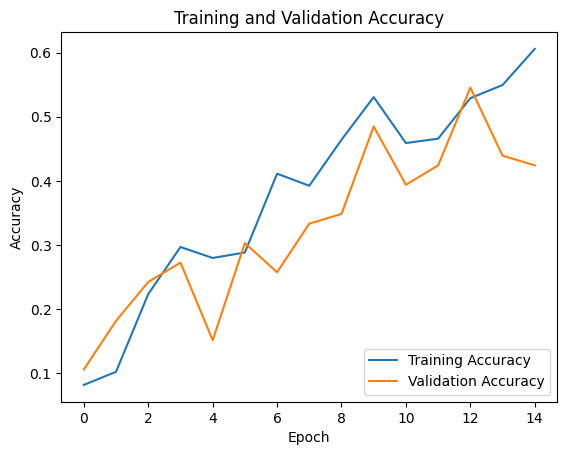

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

6/6 [==============================] - 2s 216ms/step


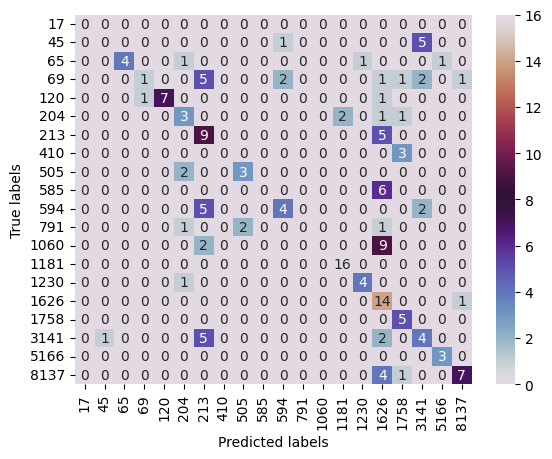

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

y_pred_ids = [index_to_id_mapping[label] for label in y_pred_labels]
y_true_ids = [index_to_id_mapping[label] for label in y_true_labels]

conf_matrix = confusion_matrix(y_true_ids, y_pred_ids, labels=list(index_to_id_mapping.values()))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=list(index_to_id_mapping.values()), yticklabels=list(index_to_id_mapping.values()), cmap="twilight")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

In [ ]:
print(conf_matrix)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  5  0  0]
 [ 0  0  4  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  1  0]
 [ 0  0  0  1  0  0  5  0  0  0  2  0  0  0  0  1  1  2  0  1]
 [ 0  0  0  1  7  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  3  0  0  0  0  0  0  0  2  0  1  1  0  0  0]
 [ 0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  5  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  2  0  0  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  0  0  4  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  1  0  0  2  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0

In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.5121951219512195
F1 Score: 0.4597684602546845
Precision: 0.48658649954381666
Recall: 0.5121951219512195


## LSTM + GRU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.LSTM(256, return_sequences=True)(emb)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.GRU(128, return_sequences=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.1)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)


model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 8000)              0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 8000, 300)         30000600  
                                                                 
 lstm_1 (LSTM)               (None, 8000, 256)         570368    
                                                                 
 dropout_5 (Dropout)         (None, 8000, 256)         0         
                                                                 
 gru (GRU)                   (None, 128)               148224    
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ft_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
batch_size = 32
epochs = 10

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/10
19/19 [==============================] - 189s 10s/step - loss: 2.9498 - accuracy: 0.0922 - val_loss: 2.9439 - val_accuracy: 0.1212
Epoch 2/10
19/19 [==============================] - 186s 10s/step - loss: 2.8587 - accuracy: 0.1331 - val_loss: 2.9142 - val_accuracy: 0.1212
Epoch 3/10
19/19 [==============================] - 11s 567ms/step - loss: 2.7827 - accuracy: 0.1331 - val_loss: 3.0178 - val_accuracy: 0.1515
Epoch 4/10
19/19 [==============================] - 185s 10s/step - loss: 2.6903 - accuracy: 0.1724 - val_loss: 2.8766 - val_accuracy: 0.1212
Epoch 5/10
19/19 [==============================] - 10s 556ms/step - loss: 2.6281 - accuracy: 0.1519 - val_loss: 2.9529 - val_accuracy: 0.1212
Epoch 6/10
19/19 [==============================] - 185s 10s/step - loss: 2.5827 - accuracy: 0.1706 - val_loss: 2.8460 - val_accuracy: 0.1212
Epoch 7/10
19/19 [==============================] - 11s 559ms/step - loss: 2.4552 - accuracy: 0.2304 - val_loss: 2.9089 - val_accuracy: 0.1212
Epo

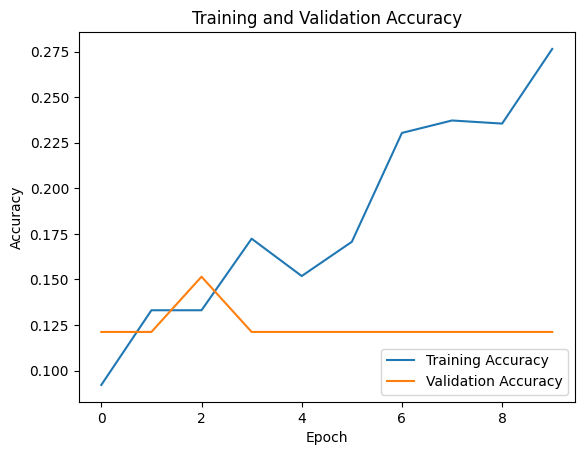

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

6/6 [==============================] - 2s 237ms/step


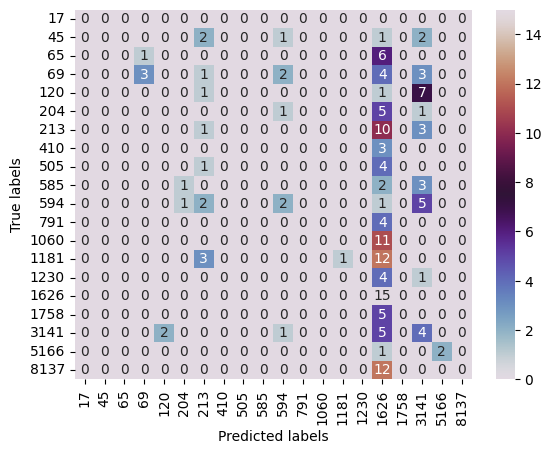

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

y_pred_ids = [index_to_id_mapping[label] for label in y_pred_labels]
y_true_ids = [index_to_id_mapping[label] for label in y_true_labels]

conf_matrix = confusion_matrix(y_true_ids, y_pred_ids, labels=list(index_to_id_mapping.values()))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=list(index_to_id_mapping.values()), yticklabels=list(index_to_id_mapping.values()), cmap="twilight")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

In [ ]:
print(conf_matrix)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  1  0  0  0  0  1  0  2  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  3  0  0  1  0  0  0  2  0  0  0  0  4  0  3  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  5  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0 10  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  2  0  3  0  0]
 [ 0  0  0  0  0  1  2  0  0  0  2  0  0  0  0  1  0  5  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  0  0  0  1  0 12  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0

In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.17073170731707318
F1 Score: 0.1127774656026556
Precision: 0.2252646240171432
Recall: 0.17073170731707318
